# Spotify 1 Million Tracks - Tratamento e Modelação

### Importe das Bibliotecas

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
%matplotlib inline


# Para visualizar os valores com cinco casas decimais
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Tratamento dos Dados

Carregar o dataset, previamente analisado

In [6]:
data = pd.read_csv('dataset/spotify_data.csv')

Eliminar coluns irrelevantes:
ids e nomes das músicas

In [7]:
# Drop Id and Track Id columns
data.drop(['Unnamed: 0', 'track_id', 'track_name'], axis=1, inplace=True, errors='ignore')

Remover outliers por género

In [8]:
"""q3 = data.groupby(by=['genre']).quantile(0.75,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']
q1 = data.groupby(by=['genre']).quantile(0.25,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']

data_aux = data.merge(q1, left_on='genre', right_index=True, suffixes=('', '_q1'))
data_aux = data_aux.merge(q3, left_on='genre', right_index=True, suffixes=('', '_q3'))
data_aux['iqr'] = data_aux['popularity_q3'] - data_aux['popularity_q1']

#data_aux
# Verificar os outliers
no_outliers = data_aux[(data_aux['popularity'] <= data_aux['popularity_q3'] + 1.5 * data_aux['iqr']) & (data_aux['popularity'] >= data_aux['popularity_q1'] - 1.5 * data_aux['iqr'])]
no_outliers.drop(['popularity_q1', 'popularity_q3', 'iqr'], axis=1, inplace=True)
no_outliers"""

"q3 = data.groupby(by=['genre']).quantile(0.75,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']\nq1 = data.groupby(by=['genre']).quantile(0.25,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']\n\ndata_aux = data.merge(q1, left_on='genre', right_index=True, suffixes=('', '_q1'))\ndata_aux = data_aux.merge(q3, left_on='genre', right_index=True, suffixes=('', '_q3'))\ndata_aux['iqr'] = data_aux['popularity_q3'] - data_aux['popularity_q1']\n\n#data_aux\n# Verificar os outliers\nno_outliers = data_aux[(data_aux['popularity'] <= data_aux['popularity_q3'] + 1.5 * data_aux['iqr']) & (data_aux['popularity'] >= data_aux['popularity_q1'] - 1.5 * data_aux['iqr'])]\nno_outliers.drop(['popularity_q1', 'popularity_q3', 'iqr'], axis=1, inplace=True)\nno_outliers"

Converter valores categóricos para valores contínuos

In [9]:
data_non_categorical = data.copy()
lb_make = LabelEncoder()
data_non_categorical['artist_name'] = lb_make.fit_transform(data_non_categorical['artist_name'])
data_non_categorical['genre'] = lb_make.fit_transform(data_non_categorical['genre'])
data_non_categorical

,artist_name,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,26235,68,2012,0,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3
1,26235,50,2012,0,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4
2,28122,57,2012,0,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4
3,7629,58,2012,0,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4
4,3014,54,2012,0,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,40236,4,2011,81,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3
1159760,40236,3,2011,81,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4
1159761,2723,2,2011,81,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4
1159762,43073,0,2011,81,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3


### Redução dimensional

Reduzir o número de features (dimensões do problema), mantendo o máximo de informação possível

AutoEncoders

In [10]:
X_reduction = data_non_categorical.drop('popularity', axis=1)
y_reduction = data_non_categorical['popularity']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduction, y_reduction, test_size=0.4, random_state=101)

In [12]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the autoencoder model
input_layer = Input(shape=(X_reduction.shape[1],))
encoded = Dense(5, activation='relu')(input_layer)
decoded = Dense(X_reduction.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, y_train, epochs=1, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

2023-11-05 17:20:35.649082: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 17:20:35.824797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 17:20:35.824830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 17:20:35.825378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 17:20:35.990988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 17:20:35.992930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

21746/21746 [==============================] - 80s 4ms/step - loss: 563.0813 - val_loss: 5381588992.0000


In [13]:
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(X_train)

encoded_features

21746/21746 [==============================] - 43s 2ms/step


array([[ 25319.172  ,  23510.203  ,  94463.484  ,  47258.55   ,
        114467.945  ],
       [ 20220.389  ,  11859.308  ,  92404.37   ,  64264.72   ,
        113554.766  ],
       [ 14853.162  ,      0.     ,  93279.37   ,  86649.73   ,
        116448.836  ],
       ...,
       [ 12376.642  ,    956.40497,  71145.734  ,  62584.812  ,
         88687.31   ],
       [ 19272.389  ,  10786.251  ,  89221.66   ,  63085.465  ,
        109660.36   ],
       [  8388.048  ,      0.     ,  55231.234  ,  54237.992  ,
         69502.05   ]], dtype=float32)

--------------

Recursive Feature Elimination

In [14]:
model = LinearRegression()

In [15]:
number_features_to_select = 10  # You can choose the number of features you want to retain
rfe = RFE(model, n_features_to_select=number_features_to_select)

In [16]:
rfe.fit(X_reduction, y_reduction)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [17]:
selected_features = X_reduction.columns[rfe.support_]
ranking = rfe.ranking_
selected_features = selected_features.append(pd.Index(['duration_ms']))

In [18]:
X_selected = X_reduction[selected_features]
X_selected

,year,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms
0,2012,0.483,0.303,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,240166
1,2012,0.572,0.454,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,216387
2,2012,0.409,0.234,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,158960
3,2012,0.392,0.251,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,304293
4,2012,0.430,0.791,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,244320
...,...,...,...,...,...,...,...,...,...,...,...
1159759,2011,0.373,0.742,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,344013
1159760,2011,0.516,0.675,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,285067
1159761,2011,0.491,0.440,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,214253
1159762,2011,0.480,0.405,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,239133


## Modelação 

Partição dos Dados entre dados de treino e teste

In [23]:
X = data_non_categorical[data_non_categorical['popularity'] > 0][selected_features]#.drop('popularity', axis=1)
y = data_non_categorical[data_non_categorical['popularity'] > 0]['popularity']
print(X)
print(y)

         year  danceability  energy  loudness  mode  speechiness  \
0        2012         0.483   0.303   -10.058     1       0.0429   
1        2012         0.572   0.454   -10.286     1       0.0258   
2        2012         0.409   0.234   -13.711     1       0.0323   
3        2012         0.392   0.251    -9.845     1       0.0363   
4        2012         0.430   0.791    -5.419     0       0.0302   
...       ...           ...     ...       ...   ...          ...   
1159758  2011         0.551   0.728    -6.904     0       0.0355   
1159759  2011         0.373   0.742    -6.453     0       0.0736   
1159760  2011         0.516   0.675    -7.588     0       0.0326   
1159761  2011         0.491   0.440    -8.512     1       0.0274   
1159763  2011         0.782   0.861    -7.292     0       0.1250   

         acousticness  instrumentalness  liveness  valence  duration_ms  
0              0.6940          0.000000    0.1150   0.1390       240166  
1              0.4770          0.00

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [4]:
sns.histplot(X_test['duration_ms'])

NameError: name 'X_test' is not defined

In [3]:
sns.histplot(y_train)

NameError: name 'y_train' is not defined

### Problema de regressão

#### Modelo de Regressão Linear

Criação do modelo

In [25]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Previsões do modelo

In [26]:
predictions = lm.predict(X_test)

Gráfico de previsão vs valor real
- X: valor real
- Y: previsão

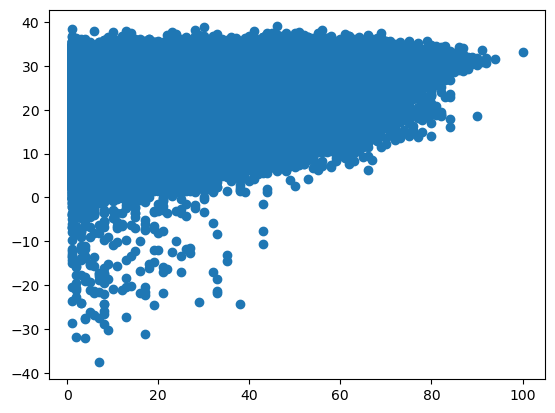

In [27]:
plt.scatter(y_test, predictions)

Valor máximo da previsão

In [28]:
predictions.max()

39.00261907095023

Comparar os valores previstos com os reais

In [29]:
pd.merge(pd.DataFrame(y_test), pd.DataFrame(predictions), left_index=True, right_index=True)    

,popularity,0
164774,14,19.374973
330544,27,17.677106
166277,26,21.200577
314202,37,31.791760
5250,19,5.216153
...,...,...
341323,57,29.145139
103993,5,12.804867
362086,38,28.231074
261823,20,27.382385


Avaliação do Modelo

In [30]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 11.157481917784521
MSE: 192.56142559975703
RMSE: 13.876650373910739


### Problema de Classificação

Uma outra forma de resolver este problema de previsão da popularidade de uma música consiste em transformar a feature 'popularity', target do nosso problema, numa feature discreta, dividindo a gama de valores contínuos (0 a 100) numa série de bins, ou seja intervalos de popularidade. Por exemplo, para 10 bins, o objetivo passaria a ser o de prever qual o nível de popularidade de uma música (Nível 0 - 0..10, Nível 1 - 10..20, etc)

Vamos então transformar a feature 'popularity' numa feature discreta, recorrendo à funcionalidade KBinsDiscretizer do módulo Sci-kit learn.
Este módulo permite realizar binning de duas estratégias diferentes:

- ‘uniform’: All bins in each feature have identical widths.

- ‘quantile’: All bins in each feature have the same number of points.

In [26]:
estimator = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['popularity_binned'] = estimator.fit_transform(data[['popularity']])
data['popularity_binned'].value_counts()
data.drop(['popularity'], axis=1)

,artist_name,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_binned
0,Jason Mraz,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3,4.0
1,Jason Mraz,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4,4.0
2,Joshua Hyslop,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4,4.0
3,Boyce Avenue,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4,4.0
4,Andrew Belle,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,Nicola Conte,2011,trip-hop,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3,1.0
1159760,Nicola Conte,2011,trip-hop,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4,1.0
1159761,Amon Tobin,2011,trip-hop,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4,0.0
1159762,Peace Orchestra,2011,trip-hop,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3,0.0


### Modelo de Árvores de Decisão

Vamos agora criar um modelo de árvores de decisão para prever o intervalo de popularidade de uma música.

In [27]:
classifier = DecisionTreeClassifier(random_state=2023)

Before training the model, we must assure that all features are non categorical.

In [28]:
continous_features = data.copy()
lb_make = LabelEncoder()
continous_features['artist_name'] = lb_make.fit_transform(continous_features['artist_name'])
continous_features['genre'] = lb_make.fit_transform(continous_features['genre'])
continous_features

,artist_name,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_binned
0,26235,68,2012,0,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3,4.0
1,26235,50,2012,0,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4,4.0
2,28122,57,2012,0,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4,4.0
3,7629,58,2012,0,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4,4.0
4,3014,54,2012,0,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,40236,4,2011,81,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3,1.0
1159760,40236,3,2011,81,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4,1.0
1159761,2723,2,2011,81,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4,0.0
1159762,43073,0,2011,81,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3,0.0


In [29]:
X_dt = continous_features.drop(['popularity', 'popularity_binned'], axis=1)
y_dt = continous_features['popularity_binned'].to_frame()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.25, random_state=101)

In [31]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2023)

In [32]:
d_tree_predictions = classifier.predict(X_test)
d_tree_predictions

array([0., 4., 2., ..., 4., 0., 1.])

In [33]:
accuracy_score(y_test, d_tree_predictions)

0.4897548121859275